In [1]:
# Basic Libraries
import pandas as pd
import seaborn as sns
import os
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats.mstats import winsorize
import scipy.stats as ss
import math
import seaborn as sns
from datetime import datetime
from numpy import absolute

In [2]:
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

In [3]:
df_raw = pd.read_csv('/home/dayu/桌面/ML/Prf_feature_train.csv',index_col=0)
label = pd.read_csv('/home/dayu/桌面/ML/Stroke_label_train.csv',index_col=0)
test_label = pd.read_csv('/home/dayu/桌面/ML/Prf_feature_test.csv',index_col=0)

In [4]:
def drop_null(data,percent):
    
      null_val_sums = data.isnull().sum() #calculate how many missing value in the column

      per_null = list(null_val_sums.values / len(data))  #calculate the missing rate

      no_null_name = []

      feature_name = list(null_val_sums.index)

      for i in range(len(per_null)):

          if per_null[i] < percent:

              no_null_name.append(i)

      newList = []

      for index in no_null_name:

          newList.append(feature_name[index])

      for aVal in newList:

          feature_name.remove(aVal)

      data_drop = data.drop(feature_name,axis=1)

      return data_drop

In [5]:
print(df_raw.shape)
df = drop_null(df_raw,0.1)#delete the feature columns with missing values more than 10%

(400000, 299)


Task 1. Stroke prediction and risk analysis on the whole population

In [6]:
# EDA
# Shape of df
print("Shape", df.shape)

# Check data types
print(df.info())

Shape (400000, 123)
<class 'pandas.core.frame.DataFrame'>
Index: 400000 entries, patient_train1 to patient_train400000
Columns: 123 entries, X_STATE to X_VEGETE1
dtypes: float64(56), int64(67)
memory usage: 378.4+ MB
None


In [7]:
# Missing Values
print('Number of missing Values by Feature\n',df.isnull().sum())
columns_with_NaNs = []
for col in df.columns:
  if df[col].isnull().sum() > 0:
    columns_with_NaNs.append(col)
print('Columns with NaNs:',columns_with_NaNs)

Number of missing Values by Feature
 X_STATE      0
FMONTH       0
IDATE        0
IMONTH       0
IDAY         0
            ..
X_VEGLT1A    0
X_FRT16A     0
X_VEG23A     0
X_FRUITE1    0
X_VEGETE1    0
Length: 123, dtype: int64
Columns with NaNs: ['GENHLTH', 'PHYSHLTH', 'PRIMINSR', 'MEDCOST1', 'CHCOCNCR', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'DIABETE4', 'HAVARTH5', 'MARITAL', 'EDUCA', 'RENTHOM1', 'CPDEMO1B', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME3', 'WEIGHT2', 'HEIGHT3', 'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'USENOW3', 'ECIGNOW1', 'ALCDAY5', 'FLUSHOT7', 'PNEUVAC4', 'HIVTST7', 'FRUIT2', 'FRUITJU2', 'FVGREEN1', 'FRENCHF1', 'POTATOE1', 'VEGETAB2', 'X_METSTAT', 'X_URBSTAT', 'X_DRDXAR3', 'X_LMTACT3', 'X_LMTWRK3', 'X_PRACE1', 'X_MRACE1', 'HTIN4', 'HTM4', 'WTKG3', 'X_AIDTST4', 'FRUTDA2_']


In [8]:
# Duplicates
duplicates_count = df.duplicated().sum()
print('No. of dups:',duplicates_count)
duplicates_rows = df[df.duplicated(keep = 'last')] # Note that the last one is kept.
print('Instances that are  duplicates:\n ',duplicates_rows)

No. of dups: 0
Instances that are  duplicates:
  Empty DataFrame
Columns: [X_STATE, FMONTH, IDATE, IMONTH, IDAY, IYEAR, DISPCODE, SEQNO, X_PSU, SEXVAR, GENHLTH, PHYSHLTH, MENTHLTH, PRIMINSR, PERSDOC3, MEDCOST1, CHECKUP1, EXERANY2, BPHIGH6, CHOLCHK3, ASTHMA3, CHCSCNCR, CHCOCNCR, CHCCOPD3, ADDEPEV3, CHCKDNY2, DIABETE4, HAVARTH5, MARITAL, EDUCA, RENTHOM1, CPDEMO1B, VETERAN3, EMPLOY1, CHILDREN, INCOME3, WEIGHT2, HEIGHT3, DEAF, BLIND, DECIDE, DIFFWALK, DIFFDRES, DIFFALON, SMOKE100, USENOW3, ECIGNOW1, ALCDAY5, FLUSHOT7, PNEUVAC4, HIVTST7, FRUIT2, FRUITJU2, FVGREEN1, FRENCHF1, POTATOE1, VEGETAB2, QSTVER, QSTLANG, X_METSTAT, X_URBSTAT, X_STSTR, X_STRWT, X_RAWRAKE, X_WT2RAKE, X_IMPRACE, X_DUALUSE, X_LLCPWT2, X_LLCPWT, X_RFHLTH, X_PHYS14D, X_MENT14D, X_HLTHPLN, X_HCVU652, X_TOTINDA, X_RFHYPE6, X_CHOLCH3, HeartDisease, X_LTASTH1, X_CASTHM1, X_ASTHMS1, X_DRDXAR3, X_LMTACT3, X_LMTWRK3, X_PRACE1, X_MRACE1, X_HISPANC, X_RACE, X_RACEG21, X_RACEGR3, X_RACEPRV, X_SEX, X_AGEG5YR, X_AGE65YR, X_AGE80, X_AG

In [9]:
# Data preprocessing
# Replacing missing value with mean value of the columns
from sklearn.impute import SimpleImputer
imp_mean = imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(df)
df2 = imp_mean.transform(df)

In [10]:
# Missing Values have been solved.
print(np.isnan(df2).any())

False


In [11]:
col_names = df.columns

In [12]:
from matplotlib import pyplot                            # Import pyplot (to be able generate the barchart later in this snippet)
model = RandomForestRegressor()                         # Create an instance of a RandomForestClassifier
# fit the model
model.fit(df2, label)                  # Fit the RandomForest instance using the traiing data
# get importance 
importance = model.feature_importances_                  # The RandomForestClassifier instance computes feature importance as a bonus. Store them imprtance values in importance'.

/tmp/ipykernel_2844157/4047223602.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(df2, label)                  # Fit the RandomForest instance using the traiing data


<BarContainer object of 123 artists>

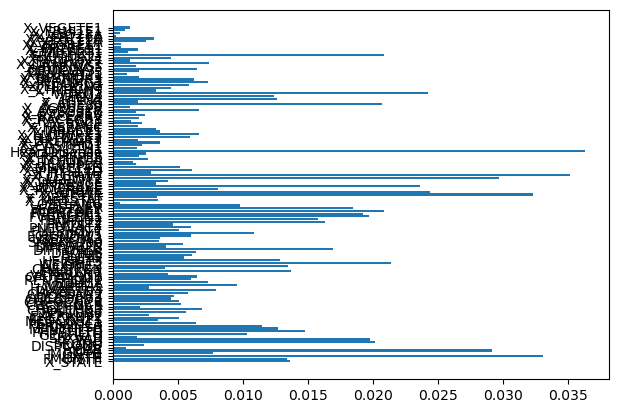

In [13]:
# summarize feature importance
plt.barh(col_names, model.feature_importances_)

In [14]:
imp = pd.DataFrame(model.feature_importances_, index=col_names)
imp.columns = ["importance"]
imp = imp.sort_values(by = ['importance'],ascending = False)
print (imp.head(12))

              importance
HeartDisease    0.036342
X_LLCPWT        0.035135
IDATE           0.033088
X_STSTR         0.032318
X_LLCPWT2       0.029687
IDAY            0.029194
X_STRWT         0.024425
WTKG3           0.024232
X_WT2RAKE       0.023584
WEIGHT2         0.021358
POTATOE1        0.020885
FRUTDA2_        0.020872


In [15]:
# Separate categoricals and quants
quants = ["X_LLCPWT","X_STSTR","X_LLCPWT2","X_STRWT","WTKG3","X_WT2RAKE","WEIGHT2","FRUTDA2_","X_AGE80"]
dummies = ["HeartDisease"]
print('Quant features: ',quants)
print('Features for dummy encoding ',dummies)

Quant features:  ['X_LLCPWT', 'X_STSTR', 'X_LLCPWT2', 'X_STRWT', 'WTKG3', 'X_WT2RAKE', 'WEIGHT2', 'FRUTDA2_', 'X_AGE80']
Features for dummy encoding  ['HeartDisease']


In [16]:
# Assess skewness of quants
df[quants].skew()
skew_cols = []
for col in quants:
  if (df[col].skew() > 1.0) or (df[col].skew() < -1):
    skew_cols.append(col)
print("Features requiring skewness correction: ",skew_cols)

Features requiring skewness correction:  ['X_LLCPWT', 'X_LLCPWT2', 'X_STRWT', 'WTKG3', 'X_WT2RAKE', 'WEIGHT2', 'FRUTDA2_']


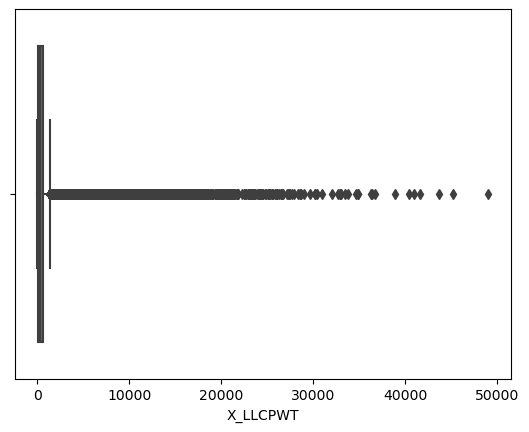

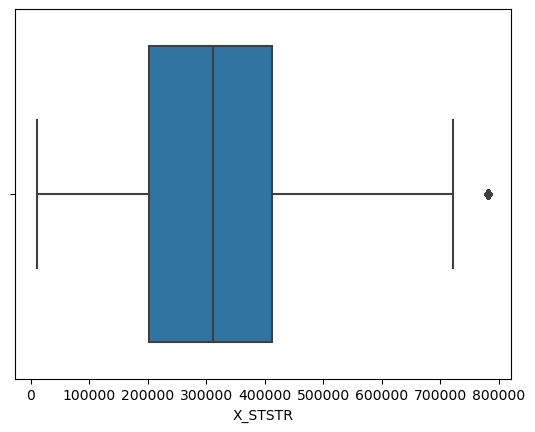

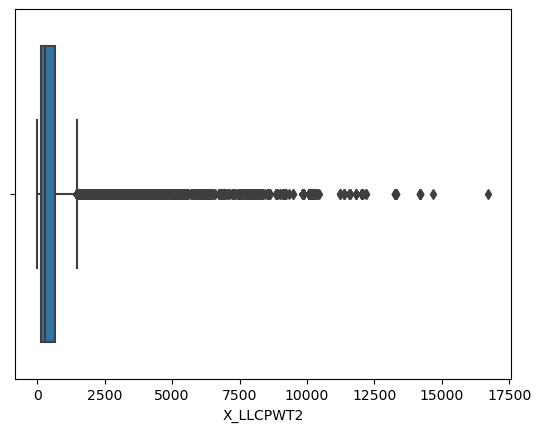

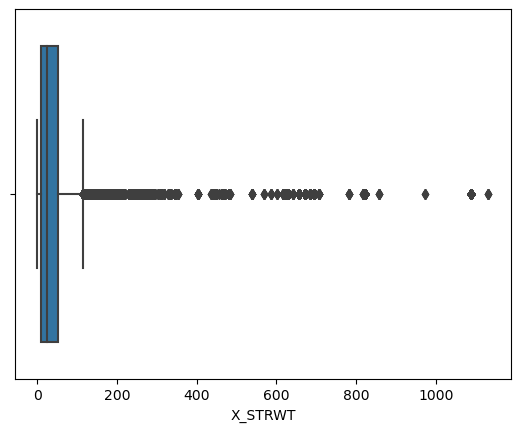

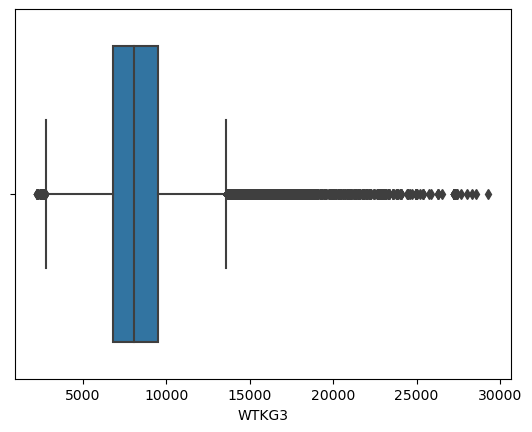

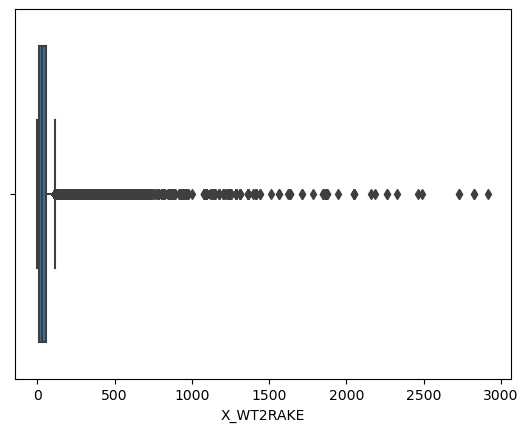

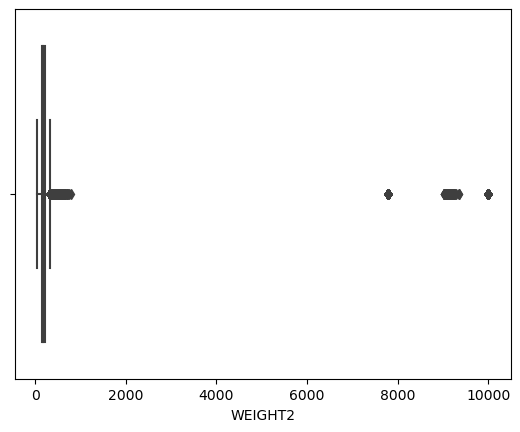

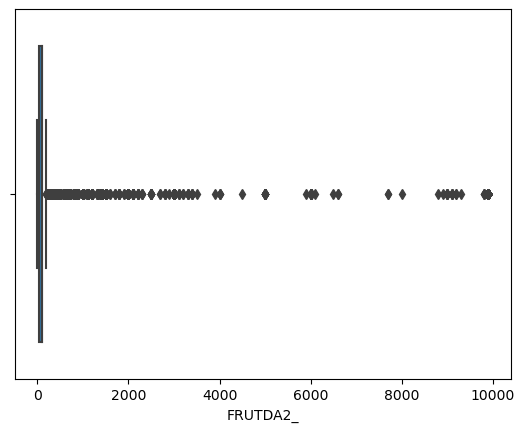

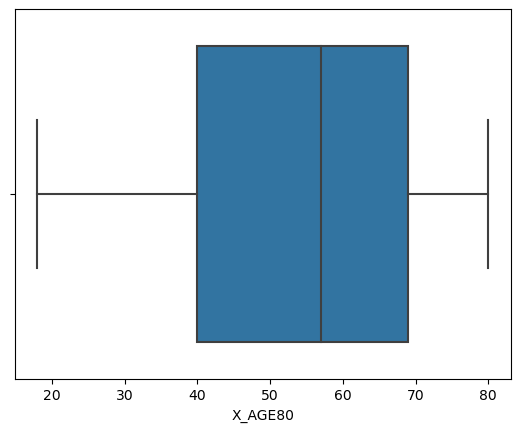

In [17]:
# Boxplot the quants to detect outliers
for col in quants:
    sns.boxplot(data=df,x=col)
    plt.show()

In [18]:
# Code for skewness correction (see source below)
# Depending upon the characteritics of a feature (column), a log, Box-Cox or power transform is applied to normalize the distribution 

# -*- coding: utf-8 -*-
"""
Created on Sat Feb 23 14:42:46 2019
@author: DATAmadness
"""

##################################################
# A function that will accept a pandas dataframe
# and auto-transforms columns that exceeds threshold value
#  -  Offers choice between boxcox or log / exponential transformation
#  -  Automatically handles negative values
#  -  Auto recognizes positive /negative skewness

# Further documentation available here:
# https://datamadness.github.io/Skewness_Auto_Transform

def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go through desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            #ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1 = sns.histplot(DF[col], ax=axes[0], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
            ax1.set(xlabel='Original ' + str(col))
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply exp transformation 
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                #ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2 = sns.histplot(DF[col], ax=axes[1], color="red", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='Transformed ' + str(col))
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                #ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2 = sns.histplot(DF[col], ax=axes[1], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='NO TRANSFORM ' + str(col))
                plt.show()
                

    return DF

In [19]:
X = df[["X_LLCPWT","X_STSTR","X_LLCPWT2","X_STRWT","WTKG3","X_WT2RAKE","WEIGHT2","FRUTDA2_","X_AGE80","HeartDisease"]]
X_test_label = test_label[["X_LLCPWT","X_STSTR","X_LLCPWT2","X_STRWT","WTKG3","X_WT2RAKE","WEIGHT2","FRUTDA2_","X_AGE80","HeartDisease"]]

In [20]:
X = skew_autotransform(X.copy(deep=True), plot = False, exp = False, threshold = 1)

In [21]:
# Tukey Rule outliers
# As an alternative, you could use z-scores greater than 3 or less than -3.

cols = X.columns
#Tukey's method
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# Identify outliers
for i in cols:
  outliers_Tukey = tukey_rule(X,i)
  
# Windsorize X and check the results
X_winsorized = X.copy(deep=True)
for i in cols:
  X_winsorized[i] = winsorize(X[i], limits=(0.05, 0.05))

In [22]:
df[['X_LLCPWT']]=X_winsorized[['X_LLCPWT']]
df[['X_STSTR']]=X_winsorized[['X_STSTR']]
df[['X_LLCPWT2']]=X_winsorized[['X_LLCPWT2']]
df[['X_STRWT']]=X_winsorized[['X_STRWT']]
df[['WTKG3']]=X_winsorized[['WTKG3']]
df[['X_WT2RAKE']]=X_winsorized[['X_WT2RAKE']]
df[['WEIGHT2']]=X_winsorized[['WEIGHT2']]
df[['FRUTDA2_']]=X_winsorized[['FRUTDA2_']]
df[['X_AGE80']]=X_winsorized[['X_AGE80']]

In [23]:
X['HeartDisease'] = df['HeartDisease']
X = X.fillna(method='backfill',axis=1)
X_test_label = X_test_label.fillna(method='backfill',axis=1)
y = label
col_names = X.columns

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

In [25]:
# Normalize
stdsc1 = StandardScaler()  
X_train_std = stdsc1.fit_transform(X_train)
X_test_std = stdsc1.transform(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
stdsc2 = StandardScaler()  
y_train_std = stdsc2.fit_transform(y_train)
y_test_std = stdsc2.transform(y_test)  

/tmp/ipykernel_2844157/4180126652.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_std, y_train)                  # Fit the RandomForest instance using the traiing data


<BarContainer object of 10 artists>

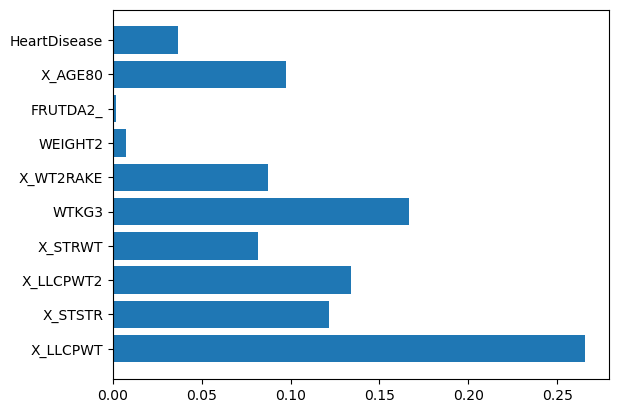

In [26]:
from matplotlib import pyplot                            # Import pyplot (to be able generate the barchart later in this snippet)
model = RandomForestRegressor()                         # Create an instance of a RandomForestClassifier
# fit the model
model.fit(X_train_std, y_train)                  # Fit the RandomForest instance using the traiing data
# get importance 
importance = model.feature_importances_                  # The RandomForestClassifier instance computes feature importance as a bonus. Store them imprtance values in importance'.
# summarize feature importance
plt.barh(col_names, model.feature_importances_)

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import lightgbm as lgb
!pip install wordcloud
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
names = ['Multiple Linear Regression', 'Lasso Regression', 'Ridge Regression','ElasticNet Regression','kNN','Multilayer Perceptron','Random Forest', 'XGBoost', 'AdaBoost','LightGBM']
regressors = [linear_model.LinearRegression(),
              Lasso(alpha=0.5),
              Ridge(alpha=0.5),
              ElasticNet(alpha=0.25, l1_ratio=0.5),
              KNeighborsRegressor(n_neighbors=5),
#              SVR(kernel = 'poly'),   #Can try kernels 'poly', 'linear', 'rbf' and 'sigmoid' kernels
              DecisionTreeRegressor(),
              MLPRegressor(hidden_layer_sizes=(50,50,1),
                       max_iter = 300,activation = 'relu',         
                       solver = 'adam'),
              RandomForestRegressor(criterion='squared_error'),
              XGBRegressor(objective ='reg:squarederror'),
              AdaBoostRegressor(loss='square'),
              lgb.LGBMRegressor(objective='mean_squared_error')
              ] 

for name, regr in zip(names, regressors):
  print('REGRESSOR: ',name)
  pipe = Pipeline(steps=[('normalize', MinMaxScaler()), ('model', regr)])
  model = TransformedTargetRegressor(regressor=pipe, transformer=MinMaxScaler())
  cv = KFold(n_splits=10, shuffle=True, random_state=1)
  scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
  score_mean = mean(absolute(scores))
  score_stdev = np.std(scores)
  print('Mean (std Dev) of MSE: %.3f (%.3f)\n' % (score_mean, score_stdev))

/home/dayu/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


REGRESSOR:  Multiple Linear Regression
Mean (std Dev) of MSE: 0.035 (0.001)

REGRESSOR:  Lasso Regression
Mean (std Dev) of MSE: 0.037 (0.001)

REGRESSOR:  Ridge Regression
Mean (std Dev) of MSE: 0.035 (0.001)

REGRESSOR:  ElasticNet Regression
Mean (std Dev) of MSE: 0.037 (0.001)

REGRESSOR:  kNN
Mean (std Dev) of MSE: 0.042 (0.001)

REGRESSOR:  Multilayer Perceptron
Mean (std Dev) of MSE: 0.076 (0.001)

REGRESSOR:  Random Forest
Mean (std Dev) of MSE: 0.036 (0.001)

REGRESSOR:  XGBoost
Mean (std Dev) of MSE: 0.038 (0.001)

REGRESSOR:  AdaBoost


/home/dayu/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/dayu/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/dayu/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/dayu/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

Mean (std Dev) of MSE: 0.036 (0.001)

REGRESSOR:  LightGBM
Mean (std Dev) of MSE: 0.117 (0.071)



In [28]:
ri = XGBRegressor(objective ='reg:squarederror')
ri.fit(X, y)
y_pred = ri.predict(X_test_label)
for i in range(len(y_pred)):
    if y_pred[i] < 1.1:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
stroke_rate = y_pred.sum()/len(y_pred)
print(stroke_rate)

/home/dayu/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.041516954014312026


/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed whe

/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed whe

/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed whe

/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/home/dayu/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed whe

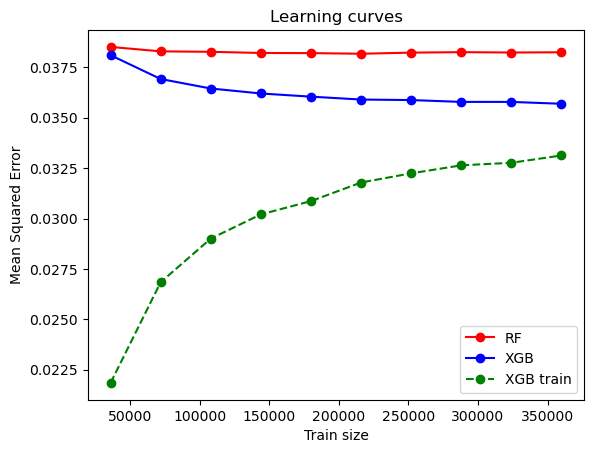

In [29]:
from sklearn.svm import SVR
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from xgboost import XGBRegressor
!pip install lightgbm
from lightgbm import LGBMRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

train_size = len(X_train)
#kNN = imbpipeline(steps = [['scaler', StandardScaler()],    
#                                ['regressor', KNeighborsRegressor(n_neighbors=5)]])

#dt = imbpipeline(steps = [['scaler', StandardScaler()],    
#                                ['regressor', DecisionTreeRegressor()]])

#svr = imbpipeline(steps = [['scaler', StandardScaler()],    
#                                ['regressor', SVR()]])

XGB = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', XGBRegressor()]])

RF = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', RandomForestRegressor()]])

#LGBM = imbpipeline(steps = [['scaler', StandardScaler()],    
#                                ['regressor', LGBMRegressor()]])


# Visualize learning curves
plt.figure()


#train_sizes, train_scores_svr, test_scores_svr = learning_curve(
#    svr,
#    X,
#    y,
#    train_sizes=np.linspace(0.1, 1, 10),
#    scoring="neg_mean_squared_error",
#    cv=10,
#)
#train_sizes_abs, train_scores_dt, test_scores_dt = learning_curve(
#    dt,
#    X,
#    y,
#    train_sizes=np.linspace(0.1, 1, 10),
#    scoring="neg_mean_squared_error",
#    cv=10,
#)
#train_sizes_abs, train_scores_kNN, test_scores_kNN = learning_curve(
#    kNN,
#    X,
#    y,
#    train_sizes=np.linspace(0.1, 1, 10),
#    scoring="neg_mean_squared_error",
#    cv=10,
#)

#plt.plot(train_sizes, -test_scores_svr.mean(1), "o-", color="r", label="SVR")
#plt.plot(train_sizes, -train_scores_svr.mean(1), "o--", color="r", label="SVR train")
#plt.plot(train_sizes, -test_scores_dt.mean(1), "o-", color="g", label="DT")
#plt.plot(train_sizes, -train_scores_dt.mean(1), "o--", color="g", label="DT train")
#plt.plot(train_sizes, -test_scores_kNN.mean(1), "o-", color="b", label="KNN")
#plt.plot(train_sizes, -train_scores_kNN.mean(1), "o--", color="b", label="KNN train")
#plt.xlabel("Train size")
#plt.ylabel("Mean Squared Error")
#plt.title("Learning curves")
#plt.legend(loc="best")

#plt.show()


train_sizes, train_scores_RF, test_scores_RF = learning_curve(
    RF,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=10,
)
train_sizes_abs, train_scores_XGB, test_scores_XGB = learning_curve(
    XGB,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=10,
)
#train_sizes_abs, train_scores_LGBM, test_scores_LGBM = learning_curve(
#    LGBM,
#    X,
#    y,
#    train_sizes=np.linspace(0.1, 1, 10),
#    scoring="neg_mean_squared_error",
#    cv=10,
#)
plt.plot(train_sizes, -test_scores_RF.mean(1), "o-", color="r", label="RF")
#plt.plot(train_sizes, -test_scores_LGBM.mean(1), "o-", color="g", label="LGBM")
plt.plot(train_sizes, -test_scores_XGB.mean(1), "o-", color="b", label="XGB")
plt.plot(train_sizes, -train_scores_XGB.mean(1), "o--", color="g", label="XGB train")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()

Task 2. Stroke prediction and risk analysis on heart disease patients

In [84]:
df_raw['label'] = label

In [85]:
#Select the heart disease patients
df_raw_HD = df_raw.loc[df['HeartDisease']== 1]
test_label_HD = test_label.loc[test_label['HeartDisease']== 1]

In [86]:
print(df_raw_HD.shape)
df_HD = drop_null(df_raw_HD,0.1)#delete the feature columns with missing values more than 10%
print(df_HD.shape)

(32353, 300)
(32353, 132)


In [87]:
label_HD = df_HD['label']
df_HD = df_HD.drop(['label'], axis=1)
print(df_HD.shape)

(32353, 131)


In [88]:
# Data preprocessing
# Replacing missing value with mean value of the columns
imp_mean.fit(df_HD)
df_HD2 = imp_mean.transform(df_HD)

In [89]:
# Missing Values have been solved.
print(np.isnan(df_HD2).any())

False


In [90]:
col_names_HD = df_HD.columns

In [91]:
from matplotlib import pyplot                            # Import pyplot (to be able generate the barchart later in this snippet)
model_HD = RandomForestRegressor()                         # Create an instance of a RandomForestClassifier
# fit the model
model_HD.fit(df_HD2, label_HD)                  # Fit the RandomForest instance using the traiing data
# get importance 
importance_HD = model_HD.feature_importances_                  # The RandomForestClassifier instance computes feature importance as a bonus. Store them imprtance values in importance'.

<BarContainer object of 131 artists>

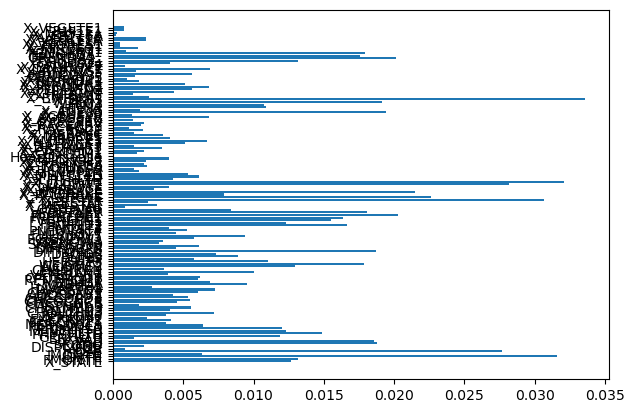

In [92]:
# summarize feature importance
plt.barh(col_names_HD, model_HD.feature_importances_)

In [93]:
imp_HD = pd.DataFrame(model_HD.feature_importances_, index=col_names_HD)
imp_HD.columns = ["importance"]
imp_HD = imp_HD.sort_values(by = ['importance'],ascending = False)
print (imp_HD.head(12))

           importance
X_BMI5       0.033611
X_LLCPWT     0.032112
IDATE        0.031627
X_STSTR      0.030682
X_LLCPWT2    0.028192
IDAY         0.027663
X_STRWT      0.022658
X_WT2RAKE    0.021502
POTATOE1     0.020314
FRUTDA2_     0.020110
X_AGE80      0.019435
WTKG3        0.019115


In [94]:
X_HD = df_HD[["X_BMI5","X_LLCPWT","X_STSTR","X_LLCPWT2","X_STRWT","X_WT2RAKE","POTATOE1","FRUTDA2_","DIFFWALK","X_AGE80"]]
X_test_label_HD = test_label_HD[["X_BMI5","X_LLCPWT","X_STSTR","X_LLCPWT2","X_STRWT","X_WT2RAKE","POTATOE1","FRUTDA2_","DIFFWALK","X_AGE80"]]

In [95]:
X_HD = skew_autotransform(X_HD.copy(deep=True), plot = False, exp = False, threshold = 1)

In [96]:
# Tukey Rule outliers
# As an alternative, you could use z-scores greater than 3 or less than -3.

cols = X_HD.columns
#Tukey's method
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# Identify outliers
for i in cols:
  outliers_Tukey = tukey_rule(X_HD,i)
  
# Windsorize X and check the results
X_winsorized = X_HD.copy(deep=True)
for i in cols:
  X_winsorized[i] = winsorize(X_HD[i], limits=(0.05, 0.05))

In [97]:
df_HD[['X_BMI5']]=X_winsorized[['X_BMI5']]
df_HD[['X_LLCPWT']]=X_winsorized[['X_LLCPWT']]
df_HD[['X_STSTR']]=X_winsorized[['X_STSTR']]
df_HD[['X_LLCPWT2']]=X_winsorized[['X_LLCPWT2']]
df_HD[['X_STRWT']]=X_winsorized[['X_STRWT']]
df_HD[['X_WT2RAKE']]=X_winsorized[['X_WT2RAKE']]
df_HD[['DIFFWALK']]=X_winsorized[['DIFFWALK']]
df_HD[['POTATOE1']]=X_winsorized[['POTATOE1']]
df_HD[['X_AGE80']]=X_winsorized[['X_AGE80']]

In [98]:
X_HD = X_HD.fillna(method='backfill',axis=1)
X_test_label_HD = X_test_label_HD.fillna(method='backfill',axis=1)
y = label_HD
col_names = X_HD.columns

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_HD, y, test_size=0.2, random_state=999)

In [100]:
# Normalize
stdsc1 = StandardScaler()  
X_train_std = stdsc1.fit_transform(X_train)
X_test_std = stdsc1.transform(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
stdsc2 = StandardScaler()  
y_train_std = stdsc2.fit_transform(y_train)
y_test_std = stdsc2.transform(y_test)  

/tmp/ipykernel_2844157/4180126652.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_std, y_train)                  # Fit the RandomForest instance using the traiing data


<BarContainer object of 10 artists>

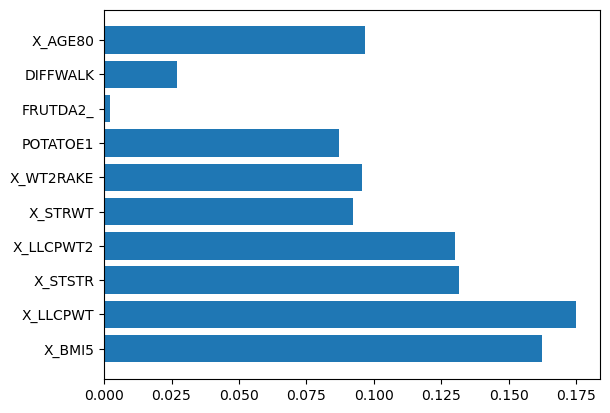

In [101]:
from matplotlib import pyplot                            # Import pyplot (to be able generate the barchart later in this snippet)
model = RandomForestRegressor()                         # Create an instance of a RandomForestClassifier
# fit the model
model.fit(X_train_std, y_train)                  # Fit the RandomForest instance using the traiing data
# get importance 
importance = model.feature_importances_                  # The RandomForestClassifier instance computes feature importance as a bonus. Store them imprtance values in importance'.
# summarize feature importance
plt.barh(col_names, model.feature_importances_)

In [102]:
names = ['Multiple Linear Regression', 'Lasso Regression', 'Ridge Regression','ElasticNet Regression','kNN','Multilayer Perceptron','Random Forest', 'XGBoost', 'AdaBoost','LightGBM']
regressors = [linear_model.LinearRegression(),
              Lasso(alpha=0.5),
              Ridge(alpha=0.5),
              ElasticNet(alpha=0.25, l1_ratio=0.5),
              KNeighborsRegressor(n_neighbors=5),
#              SVR(kernel = 'poly'),   #Can try kernels 'poly', 'linear', 'rbf' and 'sigmoid' kernels
              DecisionTreeRegressor(),
              MLPRegressor(hidden_layer_sizes=(50,50,1),
                       max_iter = 300,activation = 'relu',         
                       solver = 'adam'),
              RandomForestRegressor(criterion='squared_error'),
              XGBRegressor(objective ='reg:squarederror'),
              AdaBoostRegressor(loss='square'),
              lgb.LGBMRegressor(objective='mean_squared_error')
              ] 

for name, regr in zip(names, regressors):
  print('REGRESSOR: ',name)
  pipe = Pipeline(steps=[('normalize', MinMaxScaler()), ('model', regr)])
  model = TransformedTargetRegressor(regressor=pipe, transformer=MinMaxScaler())
  cv = KFold(n_splits=10, shuffle=True, random_state=1)
  scores = cross_val_score(model, X_HD, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
  score_mean = mean(absolute(scores))
  score_stdev = np.std(scores)
  print('Mean (std Dev) of MSE: %.3f (%.3f)\n' % (score_mean, score_stdev))

REGRESSOR:  Multiple Linear Regression
Mean (std Dev) of MSE: 0.137 (0.005)

REGRESSOR:  Lasso Regression
Mean (std Dev) of MSE: 0.136 (0.005)

REGRESSOR:  Ridge Regression
Mean (std Dev) of MSE: 0.137 (0.005)

REGRESSOR:  ElasticNet Regression
Mean (std Dev) of MSE: 0.136 (0.005)

REGRESSOR:  kNN
Mean (std Dev) of MSE: 0.161 (0.007)

REGRESSOR:  Multilayer Perceptron
Mean (std Dev) of MSE: 0.272 (0.007)

REGRESSOR:  Random Forest
Mean (std Dev) of MSE: 0.136 (0.004)

REGRESSOR:  XGBoost
Mean (std Dev) of MSE: 0.141 (0.003)

REGRESSOR:  AdaBoost


/home/dayu/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/dayu/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/dayu/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/dayu/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

Mean (std Dev) of MSE: 0.140 (0.004)

REGRESSOR:  LightGBM
Mean (std Dev) of MSE: 0.216 (0.032)



In [106]:
#stroke rate in prediction label set with heart disease
ri = XGBRegressor(objective ='reg:squarederror')
ri.fit(X_HD, y)
y_pred = ri.predict(X_test_label_HD)
for i in range(len(y_pred)):
    if y_pred[i] < 1.15:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
stroke_rate = y_pred.sum()/len(y_pred)
print(stroke_rate)

0.13951789627465302


In [80]:
#stroke rate in training label set with heart disease
testlabel = label_HD
for i in range(len(testlabel)):
    if testlabel[i] < 1.1:
        testlabel[i] = 1
    else:
        testlabel[i] = 0
stroke_rate2 = testlabel.sum()/len(testlabel)
print(stroke_rate2)

0.1626124316137607


In [116]:
from sklearn.metrics import f1_score
y_pred_train = ri.predict(X_HD)
for i in range(len(y_pred_train)):
    if y_pred_train[i] < 1.15:
        y_pred_train[i] = 1
    else:
        y_pred_train[i] = 2
micro_f1 = f1_score(y, y_pred_train, average='micro')
print(micro_f1)

0.8395202917812876


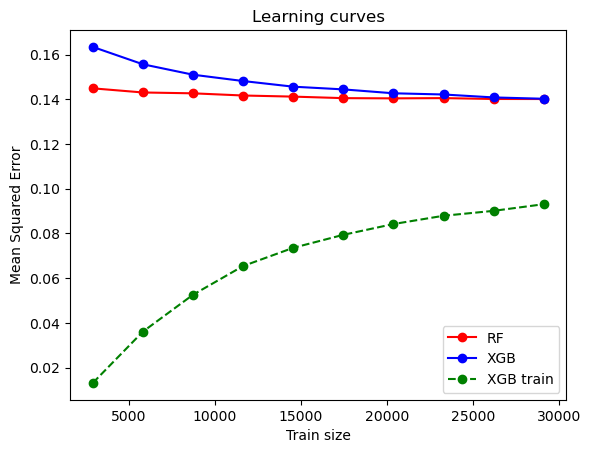

In [108]:
train_size = len(X_train)
#kNN = imbpipeline(steps = [['scaler', StandardScaler()],    
#                                ['regressor', KNeighborsRegressor(n_neighbors=5)]])

#dt = imbpipeline(steps = [['scaler', StandardScaler()],    
#                                ['regressor', DecisionTreeRegressor()]])

#svr = imbpipeline(steps = [['scaler', StandardScaler()],    
#                                ['regressor', SVR()]])

XGB = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', XGBRegressor()]])

RF = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', RandomForestRegressor()]])

#LGBM = imbpipeline(steps = [['scaler', StandardScaler()],    
#                                ['regressor', LGBMRegressor()]])


# Visualize learning curves
plt.figure()


#train_sizes, train_scores_svr, test_scores_svr = learning_curve(
#    svr,
#    X,
#    y,
#    train_sizes=np.linspace(0.1, 1, 10),
#    scoring="neg_mean_squared_error",
#    cv=10,
#)
#train_sizes_abs, train_scores_dt, test_scores_dt = learning_curve(
#    dt,
#    X,
#    y,
#    train_sizes=np.linspace(0.1, 1, 10),
#    scoring="neg_mean_squared_error",
#    cv=10,
#)
#train_sizes_abs, train_scores_kNN, test_scores_kNN = learning_curve(
#    kNN,
#    X,
#    y,
#    train_sizes=np.linspace(0.1, 1, 10),
#    scoring="neg_mean_squared_error",
#    cv=10,
#)

#plt.plot(train_sizes, -test_scores_svr.mean(1), "o-", color="r", label="SVR")
#plt.plot(train_sizes, -train_scores_svr.mean(1), "o--", color="r", label="SVR train")
#plt.plot(train_sizes, -test_scores_dt.mean(1), "o-", color="g", label="DT")
#plt.plot(train_sizes, -train_scores_dt.mean(1), "o--", color="g", label="DT train")
#plt.plot(train_sizes, -test_scores_kNN.mean(1), "o-", color="b", label="KNN")
#plt.plot(train_sizes, -train_scores_kNN.mean(1), "o--", color="b", label="KNN train")
#plt.xlabel("Train size")
#plt.ylabel("Mean Squared Error")
#plt.title("Learning curves")
#plt.legend(loc="best")

#plt.show()


train_sizes, train_scores_RF, test_scores_RF = learning_curve(
    RF,
    X_HD,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=10,
)
train_sizes_abs, train_scores_XGB, test_scores_XGB = learning_curve(
    XGB,
    X_HD,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=10,
)
#train_sizes_abs, train_scores_LGBM, test_scores_LGBM = learning_curve(
#    LGBM,
#    X_HD,
#    y,
#    train_sizes=np.linspace(0.1, 1, 10),
#    scoring="neg_mean_squared_error",
#    cv=10,
#)
plt.plot(train_sizes, -test_scores_RF.mean(1), "o-", color="r", label="RF")
#plt.plot(train_sizes, -test_scores_LGBM.mean(1), "o-", color="g", label="LGBM")
plt.plot(train_sizes, -test_scores_XGB.mean(1), "o-", color="b", label="XGB")
plt.plot(train_sizes, -train_scores_XGB.mean(1), "o--", color="g", label="XGB train")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()

In [123]:
n = 2
rs = 2022

In [124]:
kmeans = KMeans(n_clusters=n, random_state=rs)

In [130]:
label_pred1= kmeans.fit(X_HD)

In [131]:
centroid = kmeans.cluster_centers_
print(centroid)
print(centroid.shape)

[[2.62451628e+29 5.25278529e+00 3.11226936e+05 5.78727098e+00
  3.13493720e+00 3.30306646e+00 2.08291207e+22 4.30016733e+27
  4.17147371e+04 4.45682352e+05]
 [8.96993394e+28 5.42014106e+00 2.99188940e+05 6.12105960e+00
  3.34508076e+00 3.47871052e+00 5.76932999e+22 8.38638566e+32
  2.54816932e+04 4.48500921e+05]]
(2, 10)


/home/dayu/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


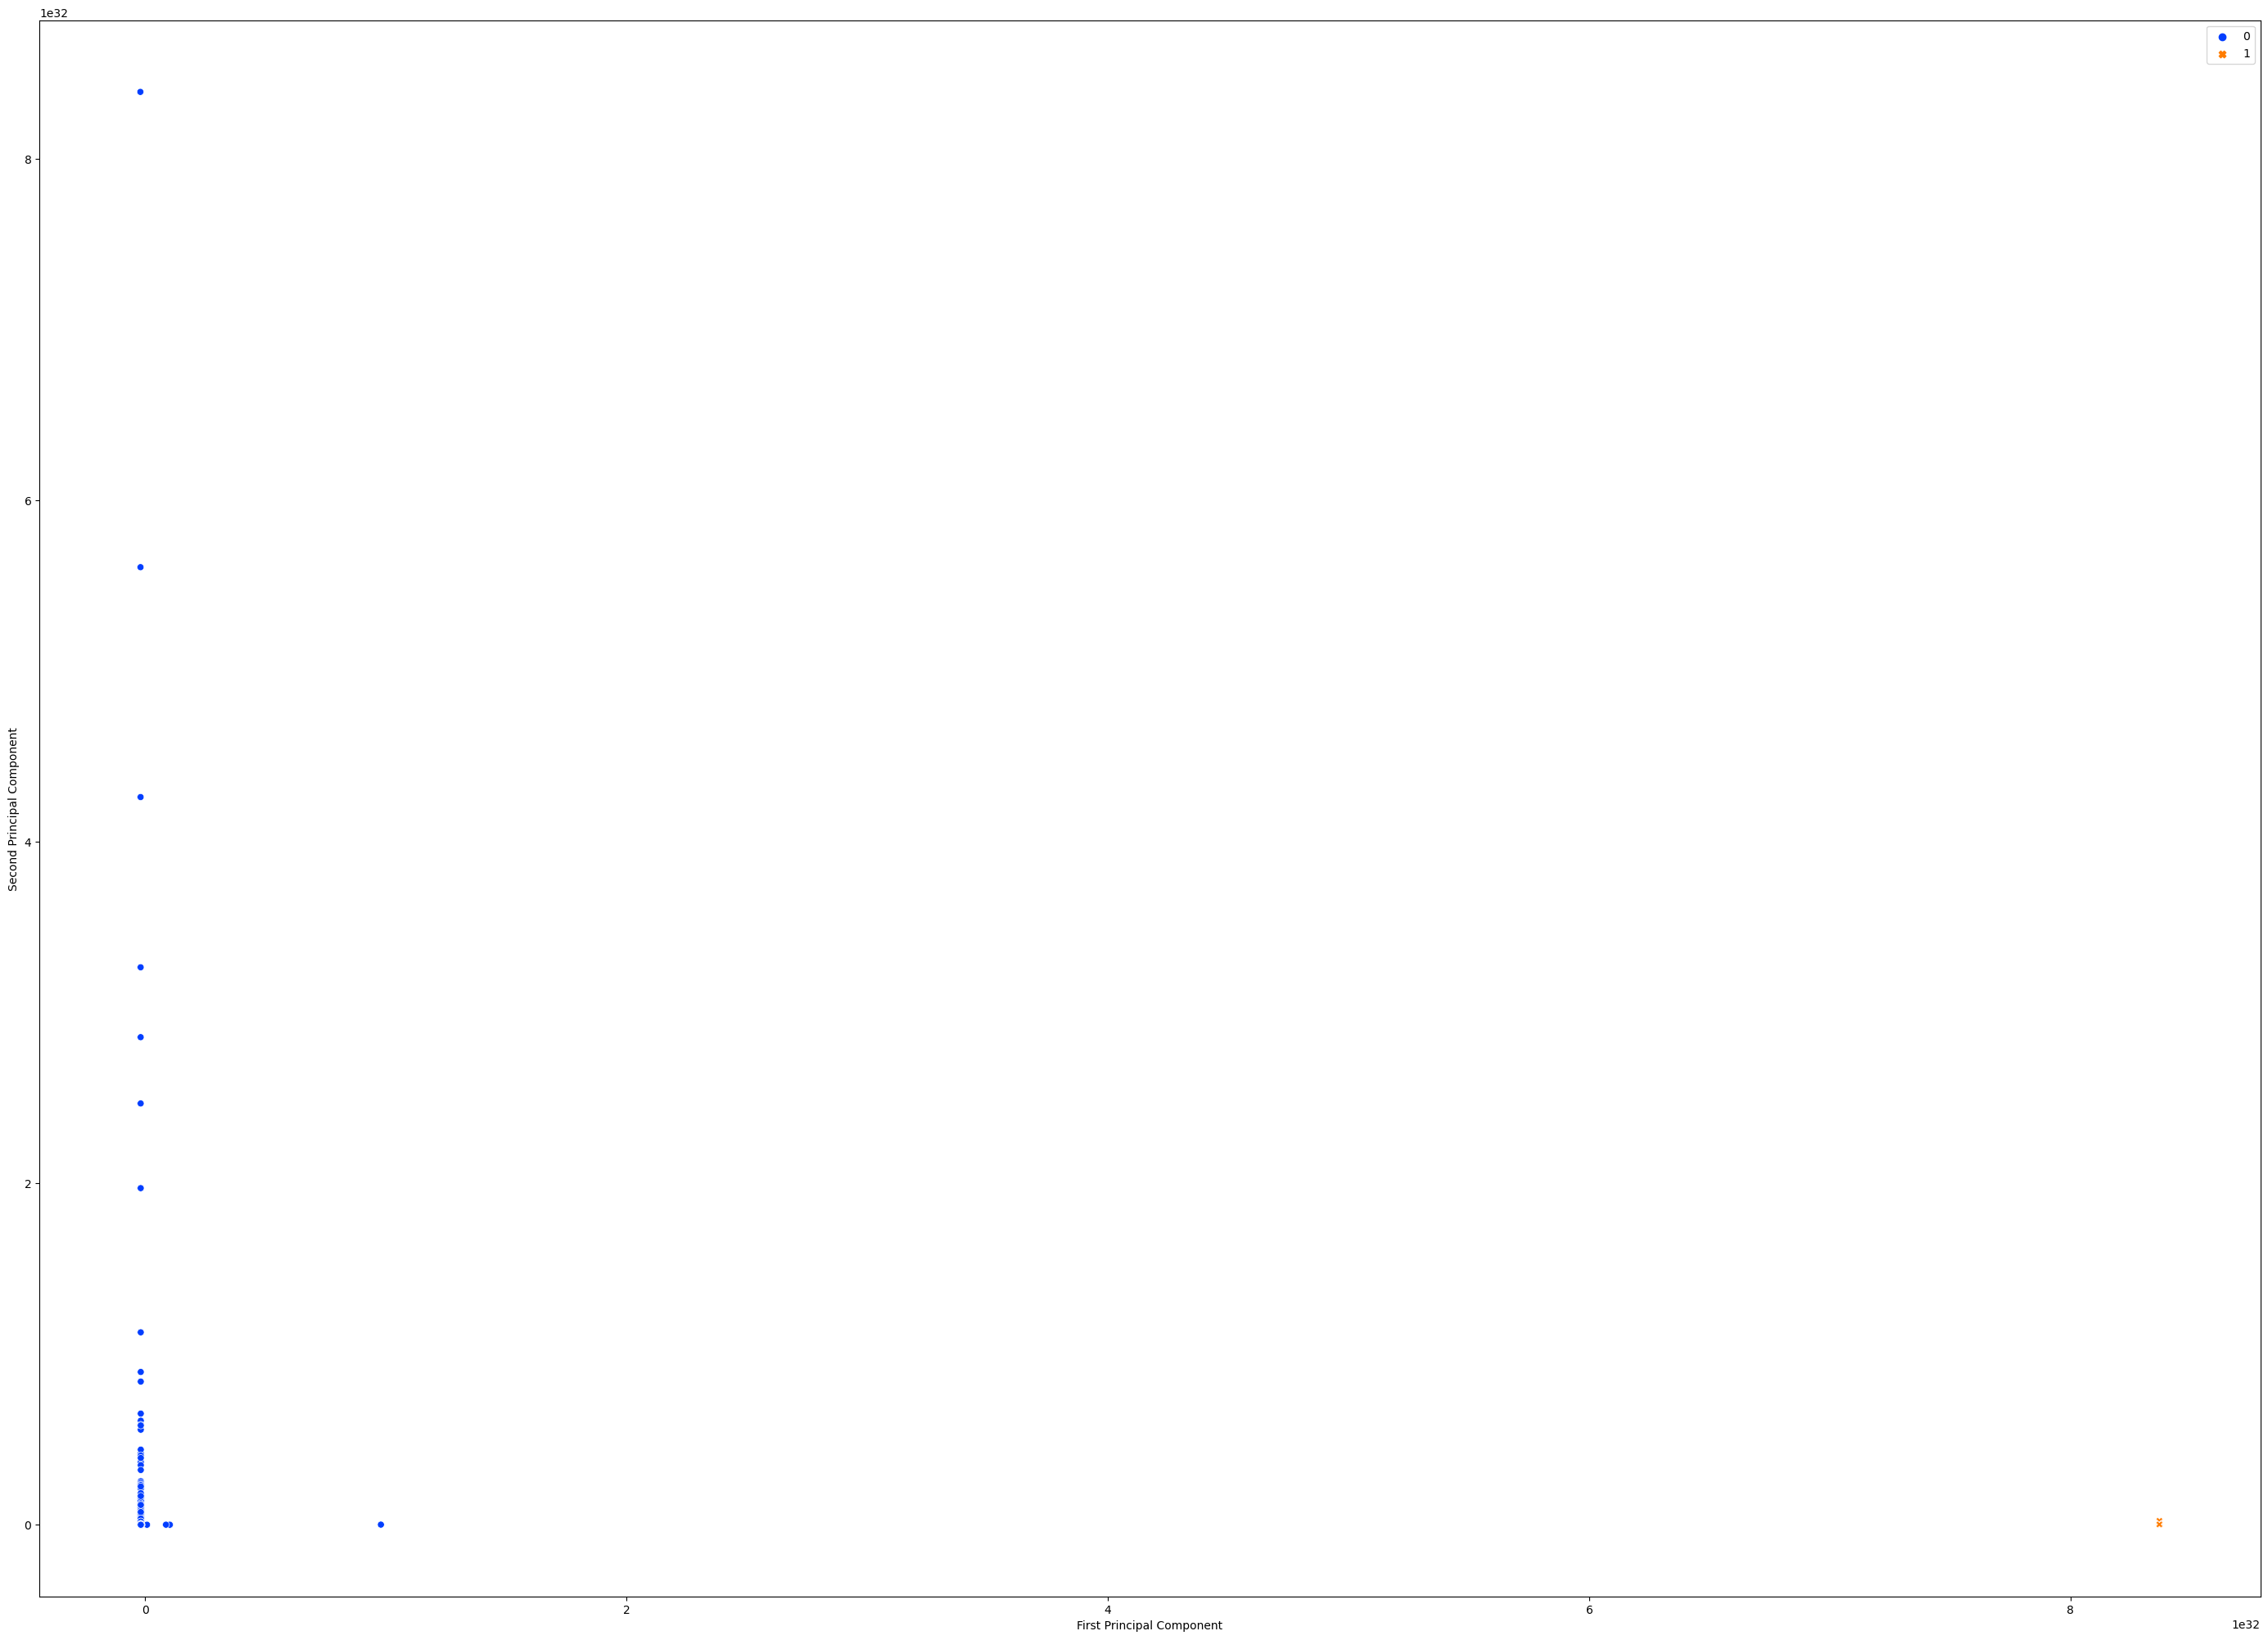

In [137]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_x = pca.fit_transform(X_HD)
import seaborn as sns
plt.figure(figsize=(35,25))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
sns.scatterplot(pca_x[:,0], pca_x[:,1], hue=label_pred1.labels_, palette="bright", style=label_pred1.labels_)
plt.show()